# Maximum Entropy Deep Inverse Reinforcement Learning
Based on the paper "Maximum Entropy Deep Inverse Reinforcement Learning" by Wulfmeier et al. [\[1\]](#references).

[CS 285: Lecture 19, Control as Inference, Part 1](https://www.youtube.com/watch?v=MzVlYYGtg0M&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=77) --> Introduce the concept of computing the backward and forward pass, used later in the Maximum Entropy Inverse Reinforcement Learning paper [\[2\]](#references).
[CS 285: Lecture 19, Control as Inference, Part 2](https://www.youtube.com/watch?v=1NgU3EKHlpY&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=78) -->

\begin{equation}

    \beta_t(s_t,a_t) = P(\mathcal{O}_{t:T} | s_t, a_t) \propto \exp(r(s_t, a_t))

\end{equation}

\begin{equation}

    \pi(s_t) = P(a_t | s_t, \mathcal{O}_{1:T}) = \frac{\beta_t(s_t, a_t)}{\beta_t(s_t)}

\end{equation}

\begin{equation}

    \alpha_t(s_t) = P(s_t | \mathcal{O}_{1:t-1})

\end{equation}

Where $\beta$ is the backward message, $\pi$ the policy, $\alpha$ the forward messages, $t:T$ means from time $t$ to the end of the trajectory, and where $\mathcal{O}$ is the probability of optimality/observed.

### Backward pass
The backward pass is defined as the probability of the trajectory given the state and action at time $t$. And can be rewritten as a recursive function as shown by [CS 285: Lecture 19, Control as Inference, Part 2](https://www.youtube.com/watch?v=1NgU3EKHlpY&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=78):

\begin{equation}

    \beta_t(s_t,a_t) = P(\mathcal{O}_t | s_t, a_t) \mathbb{E}_{s_{t+1} \sim P(s_{t+1} | s_t, a_t)}[\beta_{t+1}(s_{t+1})]

\end{equation}

\begin{equation}

    \beta_T(s_T) = \mathbb{E}_{a_t \sim P(a_t | s_t)}[\beta_t(s_t, a_t)]

\end{equation}

But this approach is not ideal as it modified the dynamics hence, the transition probabilities.

### Compute the policy

\begin{equation}

    \pi(s_t) = P(a_t | s_t, \mathcal{O}_{1:T}) = \frac{\beta_t(s_t, a_t)}{\beta_t(s_t)}

\end{equation}

Could be rewritten as the exponantial of the advantage function $\mathcal{A}$ as shown in [CS 285: Lecture 19, Control as Inference, Part 2](https://www.youtube.com/watch?v=1NgU3EKHlpY&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=78) where we can add a temperature parameter $\alpha$ where the policy approaches the greedy policy as $\alpha$ approaches 0:

\begin{equation}

    \pi(a_t | s_t) = \exp(\frac{1}{\alpha}Q_t(s_t, a_t) - \frac{1}{\alpha}V_t(s_t)) = \exp(\frac{1}{\alpha}\mathcal{A}_t(s_t, a_t))

\end{equation}

### Forward pass
The forward pass is defined as the probability of the state at time $t$ given the observations from time $1$ to $t-1$. And can be rewritten as a recursive function as shown by [CS 285: Lecture 19, Control as Inference, Part 2](https://www.youtube.com/watch?v=1NgU3EKHlpY&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=78):

\begin{equation}

    \alpha_t(s_t) = P(s_t | \mathcal{0}_{1:t-1}) \propto \int \frac{\mathcal{P} \mathcal{R} \alpha_{t-1}(s_{t-1})}{P(\mathcal{O}_{t-1} | \mathcal{O}_{1:t-2})} ds_{t-1} da_{t-1}
    
\end{equation}

Where $\mathcal{P}$ is the transition probabilities, $\mathcal{R}$ the reward function, and $P(\mathcal{O}_{t-1} | \mathcal{O}_{1:t-2})$ is the probability of the observations at time $t-1$ given the observations from time $1$ to $t-2$.

### Estimating the expectation
[CS 285: Lecture 20, Inverse Reinforcement Learning, Part 2](https://www.youtube.com/watch?v=82Sr9YqeQNc&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=83) -->

\begin{equation}

    \mu_t(s_t, a_t) \propto \beta(s_t, a_t) \alpha(s_t)

\end{equation}

Where $\mu_t$ is the state-action marginals.

### Approximation in High Dimensional Spaces and in Continuous Spaces
According to [CS 285: Lecture 20, Inverse Reinforcement Learning, Part 3](https://www.youtube.com/watch?v=OsO2nLfxZVQ&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=84) The previous techniques does not apply well to large and continuous state actions spaces problems, but it is also not robust to unknown dynamics. A solution to this problem is to use importance sampling to estimate the expectation.


In [25]:
import matplotlib.pyplot as plt
import numpy
import torch
import tqdm

## A small and simple Markov Decision Process (MDP)
Let's define the following MDP like the one used in [toy_mdp.py](../src/maxent_deep_irl/environments/toy_mdp.py). It will be use as a toy example to test the different algorithms.

<div style="text-align: center;">
    <img
        style="display: block; margin-left: auto; margin-right: auto;"
        alt="Toy MDP"
        src="../assets/toy_mdp.png">
    </img>
</div>

In [26]:
class ToyMDP():
    def __init__(self):
        self.n_states = 2
        self.n_actions = 2

        self.gamma = 0.5

        # P(s' | s, a): dim(n_states, n_states, n_actions)
        self.transition_probabilities = torch.tensor([
            [ # State 0 (s')
                # State 0, State 1 (s)
                [0.5, 0.0], # Action 0
                [0.0, 1.0]  # Action 1
            ],
            [ # State 1 (from)
                # State 0, State 1 (to)
                [0.5, 1.0], # Action 0
                [1.0, 0.0]  # Action 1
            ]
        ])

        self.reward = torch.tensor(
            [3.0, -1.0]
        )

In [27]:
mdp = ToyMDP()

# P(s' | s, a)
for s_prime in range(mdp.n_states):
    for s in range(mdp.n_states):
        for a in range(mdp.n_actions):
            print(f"P(s'={s_prime} | s={s}, a={a}) = {mdp.transition_probabilities[s_prime, s, a]}")

P(s'=0 | s=0, a=0) = 0.5
P(s'=0 | s=0, a=1) = 0.0
P(s'=0 | s=1, a=0) = 0.0
P(s'=0 | s=1, a=1) = 1.0
P(s'=1 | s=0, a=0) = 0.5
P(s'=1 | s=0, a=1) = 1.0
P(s'=1 | s=1, a=0) = 1.0
P(s'=1 | s=1, a=1) = 0.0


## Soft value iteration

Stochastic value iteration based on the paper "Maximum Entropy Deep Inverse Reinforcement Learning" by Wulfmeier et al. [\[1\]](#references). See also [CS 285: Lecture 19, Control as Inference, Part 3](https://www.youtube.com/watch?v=PAvT1Ypvmm4&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=79) by Sergey Levine.

The main difference with the deterministic value iteration algorithm is that it use a _soft max_ instead of a _max_ to compute the value function. Where _soft max_ isn't the _softmax_ function used in classical machine learning but a smooth approximation of the _max_ function below used  as the _log-sum-exp_ function from PyTorch.

\begin{equation}

    \mathcal{Q}_t(s_t, a_t) = r(s_t, a_t) + \mathbb{E}[V_{t+1}(s_{t+1})]

\end{equation}

\begin{equation}

    V_{t+1}(s_{t+1}) = \log \int \exp(\mathcal{Q}_t(s_t, a_t))da_t

\end{equation}

Variation of the previous result could be used to add a temperature parameter to the value function as shown at the end of [CS 285: Lecture 19 Control as Inference, Part 3](https://www.youtube.com/watch?v=PAvT1Ypvmm4&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=79), when this temperature parameter tend to zero, the value function tend more toward an _hard max_ value function used in the deterministic value iteration algorithm. There's also another variant that apply a discount horizon to the action-value function $\mathcal{Q}_t(s_t, a_t)$ which change the dynamics (transition probabilities) over time:

\begin{equation}

    \mathcal{Q}_t(s_t, a_t) = r(s_t, a_t) + \gamma \mathbb{E}[V_{t+1}(s_{t+1})]
    
\end{equation}

\begin{equation}

    V_t(s_t) = \alpha \log \int \exp(\frac{1}{\alpha}\mathcal{Q}_t(s_t, a_t)) da_t
    
\end{equation}

In [28]:
def soft_value_iteration(transition_probabilities, reward, gamma, epsilon, max_iteration=1000):
    """
    Args:
        transition_probabilities dim(n_states, n_states, n_actions): A tensor representing the transition probabilities of the MDP.
        reward dim(n_states): A tensor representing the reward of the MDP.
        gamma: The discount factor gamma in [0, 1].
        epsilon: A small threshold epsilon > 0 determining the accuracy of the estimation.

    Returns:
        value_function dim(n_states): The optimal value function.
        policy dim(n_states): The optimal policy.
    """
    n_states, _, n_actions = transition_probabilities.shape

    V = torch.full((n_states,), -1E6)

    for iteration in range(max_iteration):
        Vt = V.clone()

        Q = torch.zeros((n_states, n_actions))
        for s in range(n_states):
            for a in range(n_actions):
                Q[s, a] = reward[s] + gamma * torch.sum(transition_probabilities[:, s, a] * Vt)

        V = torch.logsumexp(Q, dim=1) # soft-max over actions

        delta = torch.max(torch.abs(Vt - V))

        if delta < epsilon:
            break

    pi = torch.exp(Q - V.reshape(-1, 1))

    return pi, V


# Test the value iteration algorithm
toy_mdp = ToyMDP()
policy, value_function = soft_value_iteration(toy_mdp.transition_probabilities, toy_mdp.reward, toy_mdp.gamma, epsilon=1e-5)

print(f"Value function: {value_function}")
print(f"Policy:")
print(f"\tpi(0) = {policy[0]}")
print(f"\tpi(1) = {policy[1]}")

Value function: tensor([5.0440, 1.6937])
Policy:
	pi(0) = tensor([0.6980, 0.3020])
	pi(1) = tensor([0.1577, 0.8423])


## Retrieve the optimal policy with soft value iteration
As shown in the backard pass by [\[2\]](#references) and by [CS 285: Lecture 19, Control as Inference, Part 2](https://www.youtube.com/watch?v=1NgU3EKHlpY&list=PL_iWQOsE6TfVYGEGiAOMaOzzv41Jfm_Ps&index=78), the optimal policy can also be computed as:

\begin{equation}

    \pi(a_t | s_t) = \frac{\beta_t(s_t, a_t)}{\beta_t(s_t)}

\end{equation}

In [29]:
def policy_from_soft_value_iteration(transition_probabilities, reward, gamma, epsilon=1e-5, max_iteration=1000):
    """
    Args:
        transition_probabilities dim(n_states, n_states, n_actions): A tensor representing the transition probabilities of the MDP defined as P(s' | s, a) where the dimension should correspond to the tuple (s', s, a).
        reward dim(n_states): A tensor representing the reward of the MDP per states.
        gamma: The discount factor gamma in [0, 1].

    Returns:
        policy dim(n_states, n_actions): The optimal policy P(s | a).
    """
    n_states, _, n_actions = transition_probabilities.shape

    beta_s = torch.ones(n_states)

    old_policy = torch.ones((n_states, n_actions)) / n_actions

    for iteration in range(max_iteration):
        beta_s_a = torch.sum(transition_probabilities * gamma * torch.exp(reward)[:, None, None] * beta_s[None, :, None], dim=1)
        beta_s = torch.sum(beta_s_a, dim=1)

        policy = beta_s_a / beta_s[:, None]

        delta = torch.max(torch.abs(old_policy - policy))
        if delta < epsilon:
            break

        old_policy = policy.clone()

    return policy

toy_mdp = ToyMDP()
policy  = policy_from_soft_value_iteration(toy_mdp.transition_probabilities, toy_mdp.reward, toy_mdp.gamma)
print(f"pi(0) = {policy[0]}")
print(f"pi(1) = {policy[1]}")

pi(0) = tensor([0.9066, 0.0934])
pi(1) = tensor([0.3555, 0.6445])


## Policy propagation
Algorithm 3 from the paper [\[1\]](#references) is implemented below. It could also be derived from the forward pass algorithm in [\[2, 3\]](#references)

In [30]:
def propagate_policy(policy, transition_probabilities, trajectories, initial_state_distribution):
    """
    Compute the expected state visiting frequencies by probabilistically traversing the MDP under the given policy.

    Args:
        policy dim(n_states, n_actions): The policy to propagate.
        transition_probabilities dim(n_states, n_states, n_actions): A tensor representing the transition probabilities of the MDP.
        epsilon: A small threshold epsilon > 0 determining the accuracy of the estimation.
        n_trajectories: The number of trajectories to sample.
    """
    """
    Propagate the policy through the environment dynamics as shown in the algorithm 3 of (Wulfmeir & al, 2016).

    :param policy: The policy of shape (n_states, n_actions).
    """
    n_states, _, n_actions = transition_probabilities.shape
    n_trajectories = len(trajectories)

    state_visitation_frequency = torch.zeros((n_trajectories, n_states))
    state_visitation_frequency[0] = initial_state_distribution.probs

    for t in range(1, n_trajectories):
        new_state_visitation_frequency = state_visitation_frequency.clone()
        new_state_visitation_frequency[t] = torch.sum(torch.sum(transition_probabilities * policy * state_visitation_frequency[t - 1].reshape(-1, 1), dim=1), dim=1)
        state_visitation_frequency = new_state_visitation_frequency
    state_visitation_frequency = state_visitation_frequency.sum(dim=0) / n_trajectories

    return state_visitation_frequency

## Deep Neural Network

Even though this title mentions a deep neural network, the paper [\[1\]](#references) explain that a sufficiently large neural network with at least one hidden layer can approximate the value function. Therefore, we will use a simple MLP with one hidden layer to approximate the value function.

In [31]:
class RewardNet(torch.nn.Module):
    def __init__(self, n_states):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_states, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

## Maximum Entropy Deep Inverse Reinforcement Learning
First we will use the `deterministic_value_iteration` function developed in [value_iteration.ipynb](value_iteration.ipynb) to compute the optimal value function. This will be used to retrieve the expected value differences as a metric to evaluate the training of the reward network.

In [32]:
from maxent_deep_irl import deterministic_value_iteration

As shown in the algorithm 1 and in the section 3.1. Training procedure of ([Wulfmeir & al., 2016](#references)) we will need to retrieve the state-action frequency from the demonstrations which will also be used to retrieve the feature expectation like:

\begin{equation}

    \mu_{\mathcal{D}} = \sum^{\mathcal{A}}_{a=1} \mu^a_{\mathcal{D}}

\end{equation}

In [33]:
def state_action_frequency(n_states, n_actions, trajectories):
    """
    Compute the state-action frequency from the given trajectory as shown in the section 3.1. Training Procedure of (Wulfmeir & al, 2016).
    """

    state_action_counts = torch.zeros(n_states, n_actions)
    for trajectory in trajectories:
        for state, action in trajectory:
            state_action_counts[state, action] += 1

    state_action_freq = state_action_counts.float() / len(trajectories)

    # Scale the state-action frequency to sum to 1
    state_action_freq /= state_action_freq.sum()

    return state_action_freq

def feature_expectation(demonstrations):
    """
    Compute the feature expectation from the given trajectories.
    """
    n_trajectories, n_steps, feature_dim = demonstrations.shape
    feature_expectation = torch.zeros(feature_dim)

    for trajectory in demonstrations:
        for state, _ in trajectory:
            feature_expectation[state] += 1.0

    return feature_expectation / n_trajectories

In [34]:
def maxent_deep_irl(reward_net, optimizer, transition_probabilities, reward, initial_state_distribution, epochs, gamma):
    """
    Train the reward network using the Maximum Entropy Deep Inverse Reinforcement Learning (MaxEnt Deep IRL) algorithm
    as shown in the algorithm 1 of (Wulfmeir & al, 2016).

    :return: The reward of shape (n_states,) and a dictionary of metrics accumulated during the training.
    """
    n_states, _, n_actions = transition_probabilities.shape

    optimal_value_function, _, _ = deterministic_value_iteration(transition_probabilities, reward, gamma, epsilon=1E-5)

    state_action_freq = state_action_frequency(n_states, n_actions, demonstrations)
    feature_expectation = state_action_freq.sum(dim=1)

    features = torch.eye(n_states)

    expected_value_differences = []
    losses = []
    policies = []
    rewards = []
    learned_value_function = None

    for epoch in tqdm.tqdm(range(epochs), disable=False):
        reward_estimation = reward_net(features).flatten()

        policy, learned_value_function = soft_value_iteration(transition_probabilities, reward_estimation.detach(), gamma, epsilon=1E-5)
        state_visitation_frequency = propagate_policy(policy, transition_probabilities, demonstrations, initial_state_distribution)

        expected_value_difference = torch.abs(optimal_value_function - learned_value_function)

        loss = -torch.sum(torch.log(policy + 1E-6) * state_action_freq, dim=0)
        loss_gradient = feature_expectation - state_visitation_frequency

        optimizer.zero_grad()
        reward_estimation.backward(-loss_gradient)
        optimizer.step()

        expected_value_differences.append(expected_value_difference.detach().numpy())
        losses.append(loss.detach().numpy())
        policies.append(policy.detach().numpy())
        rewards.append(reward_estimation.detach().numpy())

    metrics = {
        "expected_value_differences": expected_value_differences,
        "value_functions": learned_value_function,
        "losses": losses,
        "policies": policies,
        "rewards": rewards
    }

    reward = reward_net(features).flatten()
    return reward, metrics

## Value Iteration agent as expert demonstration
We will use an agent based on the deterministic value iteration defined in [value_iteration.py](../src/maxent_deep_irl/value_iteration.py) to generate expert demonstrations.

In [35]:
class ValueIterationAgent:
    def __init__(self, mdp, gamma=0.99, epsilon=1E-5, save_value_functions=False):
        _, self.policy, self.value_functions = deterministic_value_iteration(
            mdp.transition_probabilities,
            mdp.reward,
            gamma,
            epsilon=epsilon,
            save_value_functions=save_value_functions
        )

    def act(self, state):
        return torch.argmax(self.policy[state])

    def get_value_functions(self):
        return self.value_functions

    def get_policy(self):
        return self.policy

In [36]:
def generate_demonstrations(agent, mdp, initial_state_distribution, n_trajectories, n_steps=10, seed=0):
    torch.manual_seed(seed)
    numpy.random.seed(seed)

    demonstrations = []
    for _ in range(n_trajectories):
        trajectory = []

        # Sample initial state
        state = initial_state_distribution.sample().item()

        for _ in range(n_steps):
            action = agent.act(state).item()
            trajectory.append((state, action))
            state_probabilities = mdp.transition_probabilities[:, state, action]
            state = torch.distributions.Categorical(state_probabilities).sample().item()

        demonstrations.append(trajectory)

    return demonstrations

# Generate expert demonstrations
mdp = ToyMDP()
agent = ValueIterationAgent(mdp)

initial_state_distribution = torch.ones(mdp.n_states) / mdp.n_states
initial_state_distribution = torch.distributions.Categorical(initial_state_distribution)

demonstrations = generate_demonstrations(agent, mdp, initial_state_distribution, n_trajectories=10, n_steps=10, seed=0)

print(f"Generated {len(demonstrations)} demonstrations")
for idx, demonstration in enumerate(demonstrations[:10]):
    print(f"Trajectory {idx + 1}: {demonstration}")

Generated 10 demonstrations
Trajectory 1: [(1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1)]
Trajectory 2: [(0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
Trajectory 3: [(1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0)]
Trajectory 4: [(1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
Trajectory 5: [(0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0)]
Trajectory 6: [(1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0)]
Trajectory 7: [(0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0)]
Trajectory 8: [(0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1)]
Trajectory 9: [(1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1)]
Trajectory 10: [(1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1)]


## Training

In [37]:
mdp = ToyMDP()

expert_agent = ValueIterationAgent(mdp)

initial_state_distribution = torch.ones(mdp.n_states) / mdp.n_states
initial_state_distribution = torch.distributions.Categorical(initial_state_distribution)

demonstrations = generate_demonstrations(expert_agent, mdp, initial_state_distribution, n_trajectories=100, n_steps=30, seed=0)

reward_net = RewardNet(mdp.n_states)
optimizer = torch.optim.Adam(reward_net.parameters(), lr=1E-2)

rewards, metrics = maxent_deep_irl(reward_net, optimizer, mdp.transition_probabilities, mdp.reward, initial_state_distribution, epochs=100, gamma=mdp.gamma)

print(f"Real reward: {mdp.reward}")
print(f"Estimated reward: {rewards}")

100%|██████████| 100/100 [00:00<00:00, 113.76it/s]

Real reward: tensor([ 3., -1.])
Estimated reward: tensor([  7.7170, -11.4627], grad_fn=<ViewBackward0>)


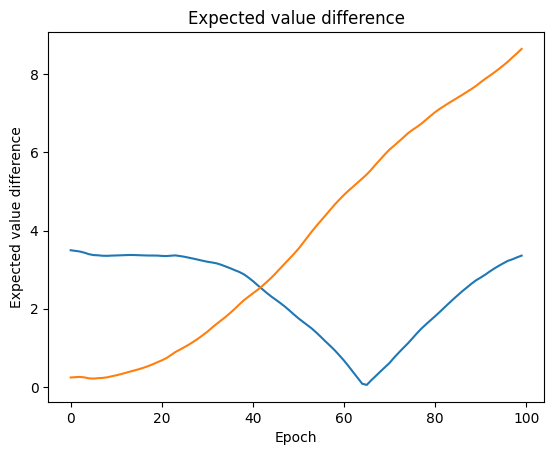

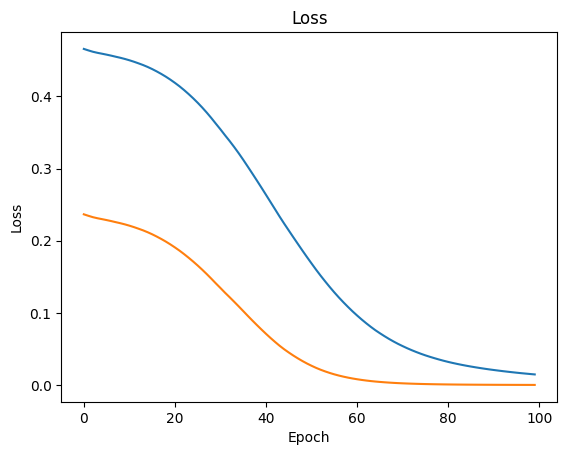

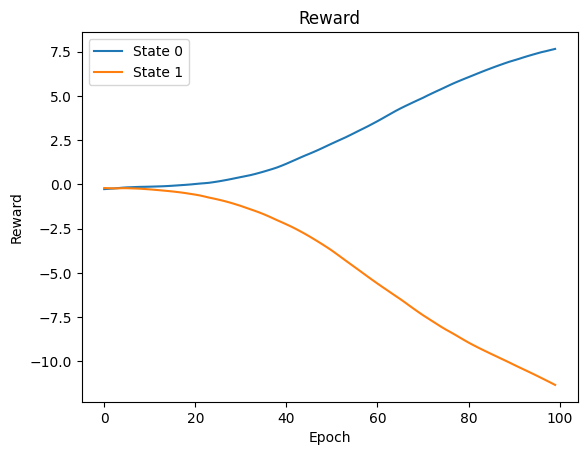

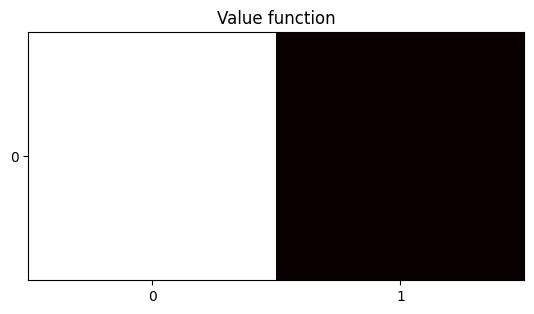

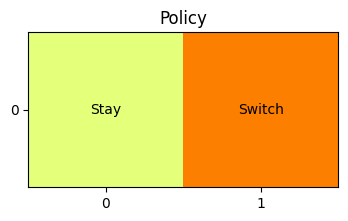

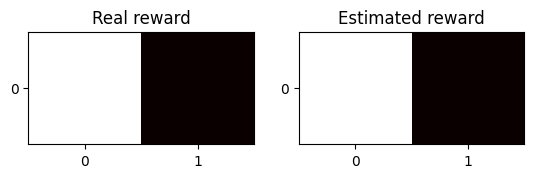

In [38]:
def plot_value_function(value_function):
    plt.figure()
    plt.imshow(value_function.reshape(1, 2), cmap="hot", interpolation="nearest")
    plt.title("Value function")
    plt.xticks(range(2))
    plt.yticks(range(1))


def plot_policy(policy):
    action_symbols = ["Stay", "Switch"]
    policy = policy.argmax(axis=1).reshape(1, 2)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    checkerboard_pattern = numpy.indices((1, 2)).sum(axis=0) % 2
    ax.imshow(checkerboard_pattern, cmap="Wistia")

    ax.set_title("Policy")
    ax.set_xticks(range(2))
    ax.set_yticks(range(1))

    for i in range(2):
        ax.text(i, 0, action_symbols[policy[0, i]], color="black", ha="center", va="center")


def plot_reward(reward, mdp):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(mdp.reward.reshape(1, 2), cmap="hot", interpolation="nearest")
    axes[0].set_title("Real reward")
    axes[0].set_xticks(range(2))
    axes[0].set_yticks(range(1))

    axes[1].imshow(reward.reshape(1, 2), cmap="hot", interpolation="nearest")
    axes[1].set_title("Estimated reward")
    axes[1].set_xticks(range(2))
    axes[1].set_yticks(range(1))


def plot_metrics(metrics, mdp):
    expected_value_differences = numpy.array(metrics["expected_value_differences"])
    losses = numpy.array(metrics["losses"])
    policies = metrics["policies"]
    rewards = numpy.array(metrics["rewards"])
    value_functions = metrics["value_functions"]

    plt.figure()
    plt.plot(expected_value_differences)
    plt.xlabel("Epoch")
    plt.ylabel("Expected value difference")
    plt.title("Expected value difference")

    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")

    plt.figure()
    for state in range(mdp.n_states):
        plt.plot(rewards[:, state], label=f"State {state}")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.title("Reward")
    plt.legend()

    plot_value_function(value_functions)
    plot_policy(policies[-1])
    plot_reward(rewards[-1], mdp)

    plt.show()

plot_metrics(metrics, mdp)

## Going further
For more complexe example take a look at the [Windy Gridworld example](../examples/windy_gridworld.py).

## References

[1]&emsp; M. Wulfmeier, P. Ondruska, et I. Posner, «Maximum Entropy Deep Inverse Reinforcement Learning». arXiv, 11 mars 2016. doi: 10.48550/arXiv.1507.04888.

[2]&emsp; B. D. Ziebart, A. Maas, J. A. Bagnell, and A. K. Dey, “Maximum entropy inverse reinforcement learning,” in Proceedings of the 23rd national conference on Artificial intelligence - Volume 3, in AAAI’08. Chicago, Illinois: AAAI Press, juillet 2008, pp. 1433–1438.

[3]&emsp; K. M. Kitani, B. D. Ziebart, J. A. Bagnell, and M. Hebert, “Activity Forecasting,” in Computer Vision – ECCV 2012, A. Fitzgibbon, S. Lazebnik, P. Perona, Y. Sato, and C. Schmid, Eds., Berlin, Heidelberg: Springer, 2012, pp. 201–214. doi: 10.1007/978-3-642-33765-9_15.